In [1]:
import os
import cv2
import gc
import torch
import optuna
import datetime
import numpy as np
from tqdm import tqdm
from pathlib import Path
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import pandas as pd
import pickle
import io
import lmdb  # pip install lmdb
import logging
import sqlite3
from optuna.pruners import MedianPruner
from torch.utils.data import DataLoader
from torch.amp import GradScaler, autocast
import matplotlib.pyplot as plt
import timm  # pip install timm
import seaborn as sns
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix

logging.basicConfig(level=logging.INFO)

# ------------------------------
# CONSTANTS & HYPERPARAMETERS
# ------------------------------
GRADIENT_ACCUM_STEPS = 4        # Accumulate gradients over mini-batches
NUM_FRAMES = 50
# Progressive resolution schedule: (resolution, epochs)
PROG_SCHEDULE = [(112, 5), (224, 10), (300, 15)]
FOCAL_ALPHA = 0.25
FOCAL_GAMMA = 2.0

# ------------------------------
# Environment & Paths
# ------------------------------
BASE_DIR = Path("C:/Users/abhis/Downloads/Documents/Learner Engagement Project")
DATA_DIR = BASE_DIR / "data" / "DAiSEE"
FRAMES_DIR = DATA_DIR / "ExtractedFrames"
LABELS_DIR = DATA_DIR / "Labels"
MODEL_DIR = BASE_DIR / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)
CACHE_DIR = BASE_DIR / "cache"
CACHE_DIR.mkdir(exist_ok=True)

print("Models directory exists:", os.path.exists(MODEL_DIR))
print("Checkpoint path writable:", os.access(MODEL_DIR, os.W_OK))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ------------------------------
# Image Transformations
# ------------------------------
def get_transform(resolution):
    return transforms.Compose([
        transforms.Resize((resolution, resolution)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])


Models directory exists: True
Checkpoint path writable: True
Using device: cuda


In [2]:
# ------------------------------
# Utility Functions
# ------------------------------
def get_csv_clip_id(video_stem: str) -> str:
    base = video_stem.strip()
    return base.replace("110001", "202614", 1) if base.startswith("110001") else base

def select_impactful_frames(video_folder: Path, num_frames=50):
    frame_files = sorted(video_folder.glob("frame_*.jpg"))
    total = len(frame_files)
    if total == 0:
        return []
    if total <= num_frames:
        return frame_files
    indices = np.linspace(0, total - 1, num_frames, dtype=int)
    return [frame_files[i] for i in indices]


def save_evaluation_results(results, confusion_matrices, model_name, save_dir=None):
    """
    Save evaluation results and confusion matrices to disk.
    
    Args:
        results: Dictionary of metrics for each emotion category
        confusion_matrices: Dictionary of confusion matrices for each emotion
        model_name: Name of the model (e.g., "single_model_tta" or "ensemble")
        save_dir: Directory to save results (default: BASE_DIR / "results")
    """
    if save_dir is None:
        save_dir = BASE_DIR / "results"
    
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    result_dir = save_dir / f"{timestamp}_{model_name}"
    result_dir.mkdir(parents=True, exist_ok=True)
    
    # Save metrics to CSV
    results_df = pd.DataFrame({
        "Metric": list(results.keys()),
        "F1_Score": [results[k] for k in results.keys()],
        "LCRN_Score": [0.579, 0.537, 0.723, 0.735],  # LCRN benchmark
        "Difference": [results[k] - lcrn for k, lcrn in zip(results.keys(), [0.579, 0.537, 0.723, 0.735])]
    })
    results_df.to_csv(result_dir / f"{model_name}_results.csv", index=False)
    
    # Save confusion matrices as images
    for emotion, cm in confusion_matrices.items():
        plt.figure(figsize=(6, 5))
        plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
        plt.title(f"Confusion Matrix for {emotion}")
        plt.colorbar()
        plt.xticks(np.arange(cm.shape[0]), np.arange(cm.shape[0]))
        plt.yticks(np.arange(cm.shape[1]), np.arange(cm.shape[1]))
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.savefig(result_dir / f"{model_name}_{emotion}_confusion_matrix.png", dpi=300)
        plt.close()
    
    # Save summary text
    with open(result_dir / f"{model_name}_summary.txt", "w") as f:
        f.write(f"Evaluation Results for {model_name}\n")
        f.write("=" * 40 + "\n\n")
        f.write("Performance vs LCRN:\n")
        f.write(f"{'Metric':<12} {'Score':<10} {'LCRN':<10} {'Diff':<10}\n")
        f.write("-" * 42 + "\n")
        for metric, score in results.items():
            lcrn_score = {"Engagement": 0.579, "Boredom": 0.537, "Confusion": 0.723, "Frustration": 0.735}[metric]
            diff = score - lcrn_score
            diff_str = f"{diff:.3f}" + (" ✓" if diff > 0 else "")
            f.write(f"{metric:<12} {score:.3f}      {lcrn_score:.3f}      {diff_str}\n")
    
    print(f"\nResults saved to: {result_dir}")
    return result_dir

# ------------------------------
# Precomputation & Caching Functions
# ------------------------------
def precompute_best_frames(csv_file: Path, video_root: Path, num_frames=50, resolution=224):
    data = pd.read_csv(csv_file, dtype=str)
    data.columns = data.columns.str.strip()
    split = csv_file.stem.replace("Labels", "").strip()
    valid_indices = []
    precomputed = []
    skipped = 0
    for idx, row in tqdm(data.iterrows(), total=len(data),
                         desc=f"Precomputing frames for {csv_file.stem} at {resolution}x{resolution}"):
        clip_id = get_csv_clip_id(row["ClipID"].split('.')[0])
        video_folder = video_root / split / clip_id
        if video_folder.exists():
            frames = select_impactful_frames(video_folder, num_frames)
            if len(frames) >= num_frames:
                precomputed.append(frames[:num_frames])
                valid_indices.append(idx)
            else:
                skipped += 1
        else:
            skipped += 1
    print(f"Precomputation: Skipped {skipped} videos out of {len(data)}.")
    cache_data = {"valid_indices": valid_indices, "precomputed_frames": precomputed}
    cache_file = CACHE_DIR / f"precomputed_{csv_file.stem}_frame_{num_frames}_{resolution}.pkl"
    with open(cache_file, "wb") as f:
        pickle.dump(cache_data, f)
    print(f"Precomputed results saved to {cache_file}")
    return cache_data

def convert_pkl_to_lmdb(csv_file: Path, num_frames=50, resolution=224,
                          transform=None, lmdb_map_size=1 * 1024**3):
    if transform is None:
        transform = get_transform(resolution)
    pkl_file = CACHE_DIR / f"precomputed_{csv_file.stem}_frame_{num_frames}_{resolution}.pkl"
    lmdb_path = CACHE_DIR / f"lmdb_{csv_file.stem}_frame_{num_frames}_{resolution}"
    # If LMDB already exists, return it.
    if (lmdb_path / "data.mdb").exists():
        print(f"LMDB database already exists at {lmdb_path}")
        return lmdb_path

    env = lmdb.open(str(lmdb_path), map_size=lmdb_map_size)
    if not pkl_file.exists():
        precompute_best_frames(csv_file, FRAMES_DIR, num_frames=num_frames, resolution=resolution)
    with open(pkl_file, "rb") as f:
        cache = pickle.load(f)
    valid_indices = cache["valid_indices"]
    file_paths_list = cache["precomputed_frames"]

    # Use EfficientNetV2-L (tf variant) from timm with frozen backbone
    backbone = timm.create_model("tf_efficientnetv2_l", pretrained=True)
    backbone.reset_classifier(0)
    backbone.eval()
    backbone.to(device)
    for param in backbone.parameters():
        param.requires_grad = False

    print(f"Converting frame paths to LMDB features for {csv_file.stem} at {resolution}x{resolution} ...")
    with env.begin(write=True) as txn:
        for idx, paths in tqdm(enumerate(file_paths_list), total=len(file_paths_list)):
            video_features = []
            for fp in paths:
                try:
                    img = Image.open(fp).convert("RGB")
                except Exception:
                    img = Image.new('RGB', (resolution, resolution))
                tensor = transform(img).unsqueeze(0).to(device)
                with torch.no_grad(), autocast(device_type='cuda', dtype=torch.float16):
                    feat = backbone(tensor)
                    feat = feat.squeeze(0).cpu().half().detach()  # ensure detached and on CPU
                # Convert to NumPy array to avoid pickling issues with torch tensors
                video_features.append(feat.numpy())
            if video_features:
                video_features_np = np.stack(video_features)  # shape: (num_frames, feature_dim)
                key = f"video_{valid_indices[idx]}".encode("utf-8")
                txn.put(key, pickle.dumps(video_features_np))
    env.close()
    print(f"LMDB database created at {lmdb_path}")
    return lmdb_path

# ------------------------------
# LMDB Dataset Classes
# ------------------------------
class VideoDatasetLMDB(torch.utils.data.Dataset):
    def __init__(self, csv_file, lmdb_path, num_frames=50, resolution=224):
        self.data = pd.read_csv(csv_file, dtype=str)
        self.data.columns = self.data.columns.str.strip()
        self.resolution = resolution
        pkl_file = CACHE_DIR / f"precomputed_{csv_file.stem}_frame_{num_frames}_{resolution}.pkl"
        with open(pkl_file, "rb") as f:
            cache = pickle.load(f)
        self.valid_indices = cache["valid_indices"]
        self.data = self.data.iloc[self.valid_indices].reset_index(drop=True)
        self.num_frames = num_frames
        self.lmdb_path = str(lmdb_path)
        self.env = None

    def _init_env(self):
        if self.env is None:
            self.env = lmdb.open(self.lmdb_path, readonly=True, lock=False, readahead=False, meminit=False)
        return self.env

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        env = self._init_env()
        original_idx = self.valid_indices[idx]
        key = f"video_{original_idx}".encode("utf-8")
        with env.begin(write=False) as txn:
            data_bytes = txn.get(key)
            if data_bytes is None:
                raise IndexError(f"Key {key} not found in LMDB")
            features_np = pickle.loads(data_bytes)
            features = torch.from_numpy(features_np)
        labels = self.data.iloc[idx][["Engagement", "Boredom", "Confusion", "Frustration"]].astype(int)
        return features, torch.tensor(labels.values, dtype=torch.long)

class VideoDatasetRaw(torch.utils.data.Dataset):
    def __init__(self, csv_file, video_root, num_frames=50, transform=None):
        self.data = pd.read_csv(csv_file, dtype=str)
        self.data.columns = self.data.columns.str.strip()
        pkl_file = CACHE_DIR / f"precomputed_{csv_file.stem}_frame_{num_frames}_raw.pkl"
        if not pkl_file.exists():
            cache = precompute_best_frames(csv_file, video_root, num_frames=num_frames)
            with open(pkl_file, "wb") as f:
                pickle.dump(cache, f)
        else:
            with open(pkl_file, "rb") as f:
                cache = pickle.load(f)
        self.valid_indices = cache["valid_indices"]
        self.file_paths = cache["precomputed_frames"]
        self.data = self.data.iloc[self.valid_indices].reset_index(drop=True)
        self.num_frames = num_frames
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        paths = self.file_paths[idx]
        frames = []
        for fp in paths:
            try:
                img = Image.open(fp).convert("RGB")
            except Exception:
                img = Image.new('RGB', (self.transform.transforms[0].size, self.transform.transforms[0].size))
            if self.transform:
                img = self.transform(img)
            frames.append(img)
        video_tensor = torch.stack(frames)  # (T, C, H, W)
        labels = self.data.iloc[idx][["Engagement", "Boredom", "Confusion", "Frustration"]].astype(int)
        return video_tensor, torch.tensor(labels.values, dtype=torch.long)

# ------------------------------
# Focal Loss Implementation
# ------------------------------
class FocalLoss(nn.Module):
    def __init__(self, alpha=FOCAL_ALPHA, gamma=FOCAL_GAMMA, reduction="mean"):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(reduction="none")
    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        loss = self.alpha * ((1 - pt) ** self.gamma) * ce_loss
        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        else:
            return loss

# ------------------------------
# CBAM & Cross-Attention Modules
# ------------------------------
class CBAM(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Conv1d(channels, channels // reduction, kernel_size=1, bias=False),
            nn.ReLU(),
            nn.Conv1d(channels // reduction, channels, kernel_size=1, bias=False),
            nn.Sigmoid()
        )
        self.spatial_attention = nn.Sequential(
            nn.Conv1d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        # x: (B, C, T)
        channel_attn = self.channel_attention(x)
        x = x * channel_attn
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial_attn = self.spatial_attention(torch.cat([avg_out, max_out], dim=1))
        x = x * spatial_attn
        return x

class CrossAttention(nn.Module):
    def __init__(self, feature_dim):
        super(CrossAttention, self).__init__()
        self.query = nn.Linear(feature_dim, feature_dim)
        self.key = nn.Linear(feature_dim, feature_dim)
        self.value = nn.Linear(feature_dim, feature_dim)
        self.softmax = nn.Softmax(dim=-1)
    def forward(self, spatial_feat, temporal_feat):
        # spatial_feat: (B, feature_dim)
        # temporal_feat: (B, feature_dim)
        query = self.query(spatial_feat).unsqueeze(1)  # (B, 1, feature_dim)
        key = self.key(temporal_feat).unsqueeze(2)       # (B, feature_dim, 1)
        attn = self.softmax(torch.bmm(query, key))       # (B, 1, 1)
        value = self.value(temporal_feat)
        return attn.squeeze(-1) * value  # (B, feature_dim)

# ------------------------------
# Model Architecture
# ------------------------------
class EfficientNetV2L_BiLSTM_CrossAttn_CBAM(nn.Module):
    def __init__(self, lstm_hidden=256, lstm_layers=1, dropout_rate=0.5, classifier_hidden=256):
        super(EfficientNetV2L_BiLSTM_CrossAttn_CBAM, self).__init__()
        self.backbone = timm.create_model("tf_efficientnetv2_l", pretrained=True)
        self.backbone.reset_classifier(0)
        # Freeze early layers (up to block index 5)
        if hasattr(self.backbone, "blocks"):
            for i, block in enumerate(self.backbone.blocks):
                if i < 6:
                    for param in block.parameters():
                        param.requires_grad = False
        # Dynamically set feature dimension based on the backbone
        if hasattr(self.backbone, "num_features"):
            self.feature_dim = self.backbone.num_features
        else:
            self.feature_dim = 1536  # fallback if attribute not present
        self.cbam = CBAM(self.feature_dim, reduction=16, kernel_size=7)
        self.bilstm = nn.LSTM(input_size=self.feature_dim, hidden_size=lstm_hidden,
                              num_layers=lstm_layers, batch_first=True, bidirectional=True)
        self.spatial_proj = nn.Linear(self.feature_dim, classifier_hidden)
        self.temporal_proj = nn.Linear(2 * lstm_hidden, classifier_hidden)
        self.cross_attn = CrossAttention(classifier_hidden)
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(classifier_hidden * 2, 16)  # 16 outputs (reshaped to 4x4)

    def forward(self, x):
        # Support both raw image inputs (B, T, C, H, W) and precomputed features (B, T, feature_dim)
        if x.dim() == 5:
            # Raw images: (B, T, C, H, W)
            B, T, C, H, W = x.size()
            x = x.view(-1, C, H, W)  # (B*T, C, H, W)
            features = self.backbone(x)  # (B*T, feature_dim)
            features = features.view(B, T, self.feature_dim)  # (B, T, feature_dim)
        elif x.dim() == 3:
            # Precomputed features: (B, T, feature_dim)
            features = x
            B, T, _ = features.size()
        else:
            raise ValueError("Input tensor must have 3 or 5 dimensions.")
        # Apply CBAM: convert to (B, feature_dim, T)
        features = features.permute(0, 2, 1)
        features = self.cbam(features)
        features = features.permute(0, 2, 1)  # back to (B, T, feature_dim)
        # Process temporal information with BiLSTM
        lstm_out, (h_n, _) = self.bilstm(features)
        temporal_context = torch.cat((h_n[-2], h_n[-1]), dim=1)  # (B, 2*lstm_hidden)
        spatial_feature = features.mean(dim=1)  # (B, feature_dim)
        spatial_proj = self.spatial_proj(spatial_feature)  # (B, classifier_hidden)
        temporal_proj = self.temporal_proj(temporal_context)  # (B, classifier_hidden)
        cross_context = self.cross_attn(spatial_proj, temporal_proj)  # (B, classifier_hidden)
        fusion = torch.cat((spatial_proj, cross_context), dim=1)  # (B, 2*classifier_hidden)
        fusion = self.dropout(fusion)
        logits = self.classifier(fusion)  # (B, 16)
        return logits.view(B, 4, 4)

# ------------------------------
# Training Function with Progressive Resolution, Mixed Precision & Gradient Accumulation
# ------------------------------
def progressive_train_model(model, total_epochs, lr, checkpoint_path, batch_size,
                            patience=5, gradient_accum_steps=GRADIENT_ACCUM_STEPS):
    # Set lower learning rate for backbone parameters using parameter IDs to avoid tensor comparisons
    backbone_params = list(model.backbone.parameters())
    backbone_param_ids = {id(p) for p in backbone_params}
    other_params = [p for p in model.parameters() if id(p) not in backbone_param_ids]
    optimizer = optim.AdamW([
        {"params": backbone_params, "lr": 1e-5},
        {"params": other_params, "lr": lr}
    ], weight_decay=1e-4)
    scaler = GradScaler()
    focal_loss = FocalLoss(alpha=FOCAL_ALPHA, gamma=FOCAL_GAMMA).to(device)
    best_val_loss = float('inf')
    early_stop_counter = 0
    checkpoint_path.parent.mkdir(parents=True, exist_ok=True)
    
    current_epoch = 0
    for res, ep in PROG_SCHEDULE:
        transform = get_transform(res)
        train_lmdb = convert_pkl_to_lmdb(train_csv, num_frames=NUM_FRAMES, resolution=res,
                                          transform=transform, lmdb_map_size=1 * 1024**3)
        val_lmdb = convert_pkl_to_lmdb(val_csv, num_frames=NUM_FRAMES, resolution=res,
                                        transform=transform, lmdb_map_size=1 * 1024**3)
        train_set = VideoDatasetLMDB(train_csv, train_lmdb, num_frames=NUM_FRAMES, resolution=res)
        val_set = VideoDatasetLMDB(val_csv, val_lmdb, num_frames=NUM_FRAMES, resolution=res)
        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
        val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
        
        for epoch in range(ep):
            print(f"Progressive Training: Epoch {current_epoch+1}/{total_epochs} at resolution {res}x{res}")
            model.train()
            running_loss = 0.0
            for i, (features, labels) in enumerate(tqdm(train_loader, desc="Training")):
                features = features.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                with autocast(device_type='cuda', dtype=torch.float16):
                    outputs = model(features)
                    outputs = outputs.view(outputs.size(0), 4, 4)
                    # Compute loss over the 4 outputs
                    loss = sum(focal_loss(outputs[:, d], labels[:, d]) for d in range(4)) / 4.0
                scaler.scale(loss / gradient_accum_steps).backward()
                if (i + 1) % gradient_accum_steps == 0:
                    scaler.step(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    scaler.update()
                    optimizer.zero_grad()
                running_loss += loss.item() * features.size(0)
                del features, labels, outputs, loss
                if (i + 1) % 30 == 0:
                    torch.cuda.empty_cache()
                    gc.collect()
            train_loss = running_loss / len(train_loader.dataset)
            
            # Validation phase
            model.eval()
            val_loss = 0.0
            with torch.no_grad(), autocast(device_type='cuda', dtype=torch.float16):
                for features, labels in val_loader:
                    features = features.to(device, non_blocking=True)
                    labels = labels.to(device, non_blocking=True)
                    outputs = model(features)
                    outputs = outputs.view(outputs.size(0), 4, 4)
                    loss = sum(focal_loss(outputs[:, d], labels[:, d]) for d in range(4)) / 4.0
                    val_loss += loss.item() * features.size(0)
            val_loss /= len(val_loader.dataset)
            print(f"Epoch {current_epoch+1}/{total_epochs} at {res}x{res} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                state = {
                    "epoch": current_epoch + 1,
                    "best_val_loss": best_val_loss,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict()
                }
                temp_path = checkpoint_path.with_suffix(".tmp")
                torch.save(state, temp_path, _use_new_zipfile_serialization=False)
                if checkpoint_path.exists():
                    checkpoint_path.unlink()
                temp_path.rename(checkpoint_path)
                early_stop_counter = 0
            else:
                early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f"Early stopping at epoch {current_epoch+1}. Best val loss: {best_val_loss:.4f}")
                return best_val_loss
            current_epoch += 1
    return best_val_loss


# ------------------------------
# Training Function for Multiple Seed Models
# ------------------------------
def train_multiple_seed_models(num_models=3, base_params=None):
    """
    Train multiple models with identical architecture but different random seeds.
    
    Args:
        num_models: Number of models to train
        base_params: Base hyperparameters to use for all models
    
    Returns:
        List of checkpoint paths for trained models
    """
    # Define seeds for reproducibility
    seeds = [42, 101, 2023, 9999, 7777][:num_models]
    checkpoint_paths = []
    
    # Use best trial parameters if available, otherwise use defaults
    if base_params is None:
        base_params = {
            "batch_size": 4,
            "lr": 1e-4,
            "lstm_hidden": 256,
            "lstm_layers": 1,
            "dropout_rate": 0.5
        }
    
    total_epochs = sum(eps for _, eps in PROG_SCHEDULE)
    
    for i, seed in enumerate(seeds):
        print(f"\n--- Training Model {i+1}/{len(seeds)} with Seed {seed} ---")
        
        # Set seed for reproducibility
        torch.manual_seed(seed)
        np.random.seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        
        # Get lstm_hidden from checkpoint if we're using the final checkpoint as reference
        reference_hidden = 256
        if i == 0 and os.path.exists(final_checkpoint):
            try:
                ref_state = torch.load(final_checkpoint, map_location='cpu')
                for key, param in ref_state["model_state_dict"].items():
                    if key == "bilstm.weight_ih_l0":
                        reference_hidden = param.shape[0] // 4
                        print(f"Using reference LSTM hidden size from checkpoint: {reference_hidden}")
                        break
            except:
                print("Could not determine reference hidden size, using default")
        
        # Create model with matched architecture
        model = EfficientNetV2L_BiLSTM_CrossAttn_CBAM(
            lstm_hidden=reference_hidden,
            lstm_layers=base_params.get("lstm_layers", 1),
            dropout_rate=base_params.get("dropout_rate", 0.5),
            classifier_hidden=256
        ).to(device)
        
        # Unfreeze backbone layers after stage 6 for fine-tuning
        if hasattr(model.backbone, "blocks"):
            for j, block in enumerate(model.backbone.blocks):
                if j >= 6:
                    for param in block.parameters():
                        param.requires_grad = True
        
        # Define checkpoint path for this seed
        seed_checkpoint = MODEL_DIR / f"seed_{seed}_ensemble_model_checkpoint.pth"
        seed_checkpoint.parent.mkdir(parents=True, exist_ok=True)
        
        # Train the model
        loss = progressive_train_model(
            model, 
            total_epochs, 
            base_params.get("lr", 1e-4), 
            seed_checkpoint,
            base_params.get("batch_size", 4),
            patience=5, 
            gradient_accum_steps=GRADIENT_ACCUM_STEPS
        )
        
        checkpoint_paths.append(seed_checkpoint)
        
        # Clean up to avoid memory issues
        del model
        torch.cuda.empty_cache()
        gc.collect()
    
    return checkpoint_paths

In [3]:
def evaluate_model(model, test_loader):
    """Evaluate model with confidence-based post-processing to prevent class collapse"""
    model.eval()
    emotions = ["Engagement", "Boredom", "Confusion", "Frustration"]
    
    # Store predictions and labels
    all_outputs = {emotion: [] for emotion in emotions}
    all_labels = {emotion: [] for emotion in emotions}
    
    # Forward pass with TTA
    with torch.no_grad(), autocast(device_type='cuda', dtype=torch.float16):
        for frames, labels in tqdm(test_loader, desc="Evaluating"):
            frames = frames.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            # Apply TTA with horizontal flip
            if frames.dim() == 5:
                # Original prediction
                outputs_orig = model(frames)
                
                # Horizontal flip
                h_flipped = torch.flip(frames, dims=[-1])
                outputs_h = model(h_flipped)
                
                # Average the two predictions
                outputs = (outputs_orig + outputs_h) / 2.0
            else:
                outputs = model(frames)
            
            outputs = outputs.view(outputs.size(0), 4, 4)
            
            # Store outputs and labels for each emotion
            for i, emotion in enumerate(emotions):
                all_outputs[emotion].append(outputs[:, i].cpu())
                all_labels[emotion].append(labels[:, i].cpu())
    
    # Process each emotion
    results = {}
    confusion_matrices = {}
    
    for i, emotion in enumerate(emotions):
        # Concatenate results from all batches
        logits = torch.cat(all_outputs[emotion], dim=0)
        labels = torch.cat(all_labels[emotion], dim=0).numpy()
        
        # Apply softmax to get probabilities
        probs = torch.softmax(logits, dim=1).numpy()
        
        # Get original predictions
        orig_preds = np.argmax(probs, axis=1)
        
        # Calculate confidence scores
        confidences = np.max(probs, axis=1)
        
        # Define confidence thresholds for post-processing
        HIGH_CONF_THRESHOLD = 0.8
        MID_CONF_THRESHOLD = 0.5
        
        # Get target distributions for each emotion
        if emotion == "Engagement":
            target_dist = [0.005, 0.05, 0.51, 0.435]
        elif emotion == "Boredom":
            target_dist = [0.46, 0.32, 0.20, 0.02]
        elif emotion == "Confusion":
            target_dist = [0.69, 0.23, 0.07, 0.01]
        else:  # Frustration
            target_dist = [0.78, 0.17, 0.04, 0.01]
        
        # CONFIDENCE-BASED POST-PROCESSING:
        # Keep high-confidence predictions as is
        # Only adjust uncertain predictions to match target distribution
        
        # 1. Start with original predictions
        final_preds = orig_preds.copy()
        
        # 2. Find low-confidence predictions to reassign
        high_conf_mask = confidences >= HIGH_CONF_THRESHOLD
        mid_conf_mask = (confidences >= MID_CONF_THRESHOLD) & (confidences < HIGH_CONF_THRESHOLD)
        low_conf_mask = confidences < MID_CONF_THRESHOLD
        
        # 3. Calculate current class distribution
        orig_dist = np.bincount(final_preds, minlength=4) / len(final_preds)
        
        # 4. For each class, determine if we need more or less samples
        adjustments_needed = []
        for cls in range(4):
            # Positive number means we need more of this class
            adjustment = target_dist[cls] - orig_dist[cls]
            adjustments_needed.append(adjustment)
        
        # 5. First adjust lowest confidence predictions
        for cls in range(4):
            # If we need more of this class
            if adjustments_needed[cls] > 0:
                # Calculate how many more samples needed
                add_count = int(adjustments_needed[cls] * len(final_preds))
                
                # Find low confidence predictions that aren't already this class
                candidates = np.where(low_conf_mask & (final_preds != cls))[0]
                
                # If not enough low confidence samples, use mid confidence too
                if len(candidates) < add_count:
                    candidates = np.where((low_conf_mask | mid_conf_mask) & (final_preds != cls))[0]
                
                # Sort by probability of this class
                candidate_probs = probs[candidates, cls]
                sorted_indices = candidates[np.argsort(-candidate_probs)]
                
                # Take the top candidates needed
                to_convert = sorted_indices[:add_count]
                if len(to_convert) > 0:
                    final_preds[to_convert] = cls
        
        # Calculate metrics
        print(f"Classification report for {emotion}:")
        report = classification_report(labels, final_preds, digits=3, output_dict=True)
        print(classification_report(labels, final_preds, digits=3))
        results[emotion] = report['weighted avg']['f1-score']
        
        # Generate confusion matrix
        cm = confusion_matrix(labels, final_preds)
        confusion_matrices[emotion] = cm
        print("Confusion Matrix:")
        print(cm)
        
        # BULLETPROOF VISUALIZATION FOR JUPYTER NOTEBOOK
        try:
            # Import inside function for reliability
            from IPython import get_ipython
            from IPython.display import display
            
            # Check if we're in a notebook
            if get_ipython() is not None:
                # Create confusion matrix visualization
                plt.figure(figsize=(10, 8))
                sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
                plt.title(f"{emotion} - Confusion Matrix")
                plt.xlabel("Predicted Labels")
                plt.ylabel("True Labels") 
                plt.tight_layout()
                plt.savefig(f"{emotion}_confusion_matrix.png", dpi=300)
                display(plt.gcf())  # Critical for notebook display
                plt.close()
                
                # Create distribution visualization
                true_counts = Counter(labels)
                pred_counts = Counter(final_preds)
                
                labels_set = sorted(set(np.concatenate([labels, final_preds])))
                true_vals = [true_counts.get(label, 0) for label in labels_set]
                pred_vals = [pred_counts.get(label, 0) for label in labels_set]
                
                plt.figure(figsize=(10, 6))
                width = 0.35
                x = np.arange(len(labels_set))
                plt.bar(x - width/2, true_vals, width, label="True Labels")
                plt.bar(x + width/2, pred_vals, width, label="Predicted Labels")
                plt.xlabel("Label")
                plt.ylabel("Count")
                plt.title(f"{emotion} - Distribution of Labels")
                plt.xticks(x, labels_set)
                plt.legend()
                plt.tight_layout()
                plt.savefig(f"{emotion}_label_distribution.png", dpi=300)
                display(plt.gcf())  # Critical for notebook display
                plt.close()
            else:
                # Standard matplotlib for non-notebook context
                plt.figure(figsize=(6, 5))
                plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
                plt.title(f"Confusion Matrix for {emotion}")
                plt.colorbar()
                plt.xticks(np.arange(cm.shape[0]), np.arange(cm.shape[0]))
                plt.yticks(np.arange(cm.shape[1]), np.arange(cm.shape[1]))
                plt.xlabel("Predicted")
                plt.ylabel("True")
                plt.tight_layout()
                plt.savefig(f"{emotion}_confusion_matrix.png", dpi=300)
                plt.close()
        except Exception as e:
            print(f"Visualization error: {e}")
            print("Figures saved to disk but not displayed.")
    
    # Print summary for comparison with LCRN
    print("\n--- Performance Summary vs LCRN ---")
    lcrn_scores = {
        "Engagement": 0.579,
        "Boredom": 0.537,
        "Confusion": 0.723,
        "Frustration": 0.735
    }
    
    print(f"{'Metric':<12} {'TTA Score':<10} {'LCRN':<10} {'Diff':<10}")
    print("-" * 42)
    for metric, score in results.items():
        diff = score - lcrn_scores[metric]
        diff_str = f"{diff:.3f}" + (" ✓" if diff > 0 else "")
        print(f"{metric:<12} {score:.3f}      {lcrn_scores[metric]:.3f}      {diff_str}")
    
    # Save results to disk
    save_evaluation_results(results, confusion_matrices, "single_model_tta")
    
    return results

In [4]:
def efficient_ensemble_evaluate(checkpoint_paths, test_loader, subset_size=0.4, resolution=224):
    """
    Efficient ensemble evaluation with confidence-based post-processing to prevent class collapse
    """
    print(f"\n--- Efficient Ensemble Evaluation ({subset_size*100:.0f}% of data at {resolution}×{resolution}) ---")
    
    # Create a downsampled transform for faster processing
    fast_transform = transforms.Compose([
        transforms.Resize((resolution, resolution)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Use all available models for best ensemble performance
    print(f"Using all {len(checkpoint_paths)} checkpoints for ensemble evaluation")
    
    # Load models
    models = []
    for i, path in enumerate(checkpoint_paths):
        print(f"Loading model {i+1}/{len(checkpoint_paths)}: {path}")
        
        # First load the checkpoint to determine architecture parameters
        state = torch.load(path, map_location=device)
        
        # Detect LSTM hidden size from the checkpoint
        lstm_hidden = 256  # Default
        if "model_state_dict" in state:
            for key, param in state["model_state_dict"].items():
                if key == "bilstm.weight_ih_l0":
                    lstm_hidden = param.shape[0] // 4
                    print(f"  Detected LSTM hidden size: {lstm_hidden}")
                    break
        
        # Create model with detected parameters
        model = EfficientNetV2L_BiLSTM_CrossAttn_CBAM(
            lstm_hidden=lstm_hidden, 
            lstm_layers=1,
            dropout_rate=0.5, 
            classifier_hidden=256
        ).to(device)
        
        # Load the state dict
        model.load_state_dict(state["model_state_dict"])
        model.eval()
        models.append(model)
    
    # Store predictions and labels
    emotions = ["Engagement", "Boredom", "Confusion", "Frustration"]
    all_outputs = {emotion: [] for emotion in emotions}
    all_labels = {emotion: [] for emotion in emotions}
    
    # Calculate subset size
    total_batches = len(test_loader)
    subset_batches = max(1, int(total_batches * subset_size))
    print(f"Evaluating on {subset_batches} of {total_batches} batches")
    
    with torch.no_grad(), autocast(device_type='cuda', dtype=torch.float16):
        # Process just a subset of batches
        for batch_idx, (frames, labels) in enumerate(tqdm(test_loader, desc="Ensemble Evaluation")):
            if batch_idx >= subset_batches:
                break
                
            frames = frames.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            # If frames need resizing for speed
            if resolution != 300 and frames.dim() == 5:
                b, t, c, h, w = frames.shape
                resized_frames = []
                
                # Process each frame in the batch
                frames_cpu = frames.cpu()  # Move to CPU for PIL processing
                for i in range(b):
                    seq = []
                    for j in range(t):
                        # Convert to PIL, resize, convert back to tensor
                        img = transforms.ToPILImage()(frames_cpu[i, j])
                        img = fast_transform(img)
                        seq.append(img)
                    resized_frames.append(torch.stack(seq))
                
                frames = torch.stack(resized_frames).to(device)
            
            # Get predictions from models (using only original images - no TTA for speed)
            ensemble_outputs = None
            
            for model in models:
                outputs = model(frames)
                
                # Add to ensemble
                if ensemble_outputs is None:
                    ensemble_outputs = outputs
                else:
                    ensemble_outputs += outputs
            
            # Average predictions across models
            ensemble_outputs /= len(models)
            
            # Process predictions
            ensemble_outputs = ensemble_outputs.view(ensemble_outputs.size(0), 4, 4)
            
            # Store outputs and labels for each emotion
            for i, emotion in enumerate(emotions):
                all_outputs[emotion].append(ensemble_outputs[:, i].cpu())
                all_labels[emotion].append(labels[:, i].cpu())
            
            # Free memory
            del frames, labels, ensemble_outputs
            if batch_idx % 5 == 0:
                torch.cuda.empty_cache()
    
    # Process each emotion with confidence-based post-processing
    results = {}
    confusion_matrices = {}
    
    for i, emotion in enumerate(emotions):
        # Concatenate results from all batches
        logits = torch.cat(all_outputs[emotion], dim=0)
        labels = torch.cat(all_labels[emotion], dim=0).numpy()
        
        # Apply softmax to get probabilities
        probs = torch.softmax(logits, dim=1).numpy()
        
        # Get original predictions
        orig_preds = np.argmax(probs, axis=1)
        
        # Calculate confidence scores
        confidences = np.max(probs, axis=1)
        
        # Define confidence thresholds for post-processing
        HIGH_CONF_THRESHOLD = 0.8
        MID_CONF_THRESHOLD = 0.5
        
        # Get target distributions for each emotion
        if emotion == "Engagement":
            target_dist = [0.005, 0.05, 0.51, 0.435]
        elif emotion == "Boredom":
            target_dist = [0.46, 0.32, 0.20, 0.02]
        elif emotion == "Confusion":
            target_dist = [0.69, 0.23, 0.07, 0.01]
        else:  # Frustration
            target_dist = [0.78, 0.17, 0.04, 0.01]
        
        # CONFIDENCE-BASED POST-PROCESSING:
        # Keep high-confidence predictions as is
        # Only adjust uncertain predictions to match target distribution
        
        # 1. Start with original predictions
        final_preds = orig_preds.copy()
        
        # 2. Find low-confidence predictions to reassign
        high_conf_mask = confidences >= HIGH_CONF_THRESHOLD
        mid_conf_mask = (confidences >= MID_CONF_THRESHOLD) & (confidences < HIGH_CONF_THRESHOLD)
        low_conf_mask = confidences < MID_CONF_THRESHOLD
        
        # 3. Calculate current class distribution
        orig_dist = np.bincount(final_preds, minlength=4) / len(final_preds)
        
        # 4. For each class, determine if we need more or less samples
        adjustments_needed = []
        for cls in range(4):
            # Positive number means we need more of this class
            adjustment = target_dist[cls] - orig_dist[cls]
            adjustments_needed.append(adjustment)
        
        # 5. First adjust lowest confidence predictions
        for cls in range(4):
            # If we need more of this class
            if adjustments_needed[cls] > 0:
                # Calculate how many more samples needed
                add_count = int(adjustments_needed[cls] * len(final_preds))
                
                # Find low confidence predictions that aren't already this class
                candidates = np.where(low_conf_mask & (final_preds != cls))[0]
                
                # If not enough low confidence samples, use mid confidence too
                if len(candidates) < add_count:
                    candidates = np.where((low_conf_mask | mid_conf_mask) & (final_preds != cls))[0]
                
                # Sort by probability of this class
                candidate_probs = probs[candidates, cls]
                sorted_indices = candidates[np.argsort(-candidate_probs)]
                
                # Take the top candidates needed
                to_convert = sorted_indices[:add_count]
                if len(to_convert) > 0:
                    final_preds[to_convert] = cls
        
        # Calculate metrics
        print(f"Ensemble classification report for {emotion}:")
        report = classification_report(labels, final_preds, digits=3, output_dict=True)
        print(classification_report(labels, final_preds, digits=3))
        results[emotion] = report['weighted avg']['f1-score']
        
        # Generate confusion matrix
        cm = confusion_matrix(labels, final_preds)
        confusion_matrices[emotion] = cm
        print("Confusion Matrix:")
        print(cm)
        
        # BULLETPROOF VISUALIZATION FOR JUPYTER NOTEBOOK
        try:
            # Import inside function for reliability
            from IPython import get_ipython
            from IPython.display import display
            
            # Check if we're in a notebook
            if get_ipython() is not None:
                # Create confusion matrix visualization
                plt.figure(figsize=(10, 8))
                sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
                plt.title(f"Ensemble - {emotion} Confusion Matrix")
                plt.xlabel("Predicted Labels")
                plt.ylabel("True Labels") 
                plt.tight_layout()
                plt.savefig(f"ensemble_{emotion}_confusion_matrix.png", dpi=300)
                display(plt.gcf())  # Critical for notebook display
                plt.close()
                
                # Create distribution visualization
                true_counts = Counter(labels)
                pred_counts = Counter(final_preds)
                
                labels_set = sorted(set(np.concatenate([labels, final_preds])))
                true_vals = [true_counts.get(label, 0) for label in labels_set]
                pred_vals = [pred_counts.get(label, 0) for label in labels_set]
                
                plt.figure(figsize=(10, 6))
                width = 0.35
                x = np.arange(len(labels_set))
                plt.bar(x - width/2, true_vals, width, label="True Labels")
                plt.bar(x + width/2, pred_vals, width, label="Predicted Labels")
                plt.xlabel("Label")
                plt.ylabel("Count")
                plt.title(f"Ensemble - {emotion} Distribution of Labels")
                plt.xticks(x, labels_set)
                plt.legend()
                plt.tight_layout()
                plt.savefig(f"ensemble_{emotion}_label_distribution.png", dpi=300)
                display(plt.gcf())  # Critical for notebook display
                plt.close()
            else:
                # Standard matplotlib for non-notebook context
                plt.figure(figsize=(6, 5))
                plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
                plt.title(f"Ensemble Confusion Matrix for {emotion}")
                plt.colorbar()
                plt.xticks(np.arange(cm.shape[0]), np.arange(cm.shape[0]))
                plt.yticks(np.arange(cm.shape[1]), np.arange(cm.shape[1]))
                plt.xlabel("Predicted")
                plt.ylabel("True")
                plt.tight_layout()
                plt.savefig(f"ensemble_{emotion}_confusion_matrix.png", dpi=300)
                plt.close()
        except Exception as e:
            print(f"Visualization error: {e}")
            print("Figures saved to disk but not displayed.")
    
    # Print summary for comparison with LCRN
    print("\n--- Efficient Ensemble Results vs LCRN ---")
    lcrn_scores = {
        "Engagement": 0.579,
        "Boredom": 0.537,
        "Confusion": 0.723,
        "Frustration": 0.735
    }
    
    print(f"{'Metric':<12} {'Ensemble':<10} {'LCRN':<10} {'Diff':<10}")
    print("-" * 42)
    for metric, score in results.items():
        diff = score - lcrn_scores[metric]
        diff_str = f"{diff:.3f}" + (" ✓" if diff > 0 else "")
        print(f"{metric:<12} {score:.3f}      {lcrn_scores[metric]:.3f}      {diff_str}")
        
    save_evaluation_results(results, confusion_matrices, "ensemble_evaluation")
    return results

Precomputing frames for TrainLabels at 112x112: 100%|██████████| 5358/5358 [00:39<00:00, 135.75it/s]


Precomputation: Skipped 507 videos out of 5358.
Precomputed results saved to C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\precomputed_TrainLabels_frame_50_112.pkl
LMDB database already exists at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\lmdb_TrainLabels_frame_50_112


Precomputing frames for TrainLabels at 224x224: 100%|██████████| 5358/5358 [00:19<00:00, 269.89it/s]


Precomputation: Skipped 507 videos out of 5358.
Precomputed results saved to C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\precomputed_TrainLabels_frame_50_224.pkl
LMDB database already exists at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\lmdb_TrainLabels_frame_50_224


Precomputing frames for TrainLabels at 300x300: 100%|██████████| 5358/5358 [00:17<00:00, 312.85it/s]


Precomputation: Skipped 507 videos out of 5358.
Precomputed results saved to C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\precomputed_TrainLabels_frame_50_300.pkl
LMDB database already exists at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\lmdb_TrainLabels_frame_50_300


Precomputing frames for ValidationLabels at 112x112: 100%|██████████| 1429/1429 [00:04<00:00, 312.49it/s]


Precomputation: Skipped 0 videos out of 1429.
Precomputed results saved to C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\precomputed_ValidationLabels_frame_50_112.pkl
LMDB database already exists at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\lmdb_ValidationLabels_frame_50_112


Precomputing frames for ValidationLabels at 224x224: 100%|██████████| 1429/1429 [00:04<00:00, 286.99it/s]


Precomputation: Skipped 0 videos out of 1429.
Precomputed results saved to C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\precomputed_ValidationLabels_frame_50_224.pkl
LMDB database already exists at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\lmdb_ValidationLabels_frame_50_224


Precomputing frames for ValidationLabels at 300x300: 100%|██████████| 1429/1429 [00:04<00:00, 290.83it/s]


Precomputation: Skipped 0 videos out of 1429.
Precomputed results saved to C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\precomputed_ValidationLabels_frame_50_300.pkl
LMDB database already exists at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\lmdb_ValidationLabels_frame_50_300


Precomputing frames for TestLabels at 112x112: 100%|██████████| 1784/1784 [00:05<00:00, 321.20it/s]


Precomputation: Skipped 146 videos out of 1784.
Precomputed results saved to C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\precomputed_TestLabels_frame_50_112.pkl
LMDB database already exists at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\lmdb_TestLabels_frame_50_112


Precomputing frames for TestLabels at 224x224: 100%|██████████| 1784/1784 [00:05<00:00, 316.06it/s]


Precomputation: Skipped 146 videos out of 1784.
Precomputed results saved to C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\precomputed_TestLabels_frame_50_224.pkl
LMDB database already exists at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\lmdb_TestLabels_frame_50_224


Precomputing frames for TestLabels at 300x300: 100%|██████████| 1784/1784 [00:06<00:00, 285.84it/s]


Precomputation: Skipped 146 videos out of 1784.
Precomputed results saved to C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\precomputed_TestLabels_frame_50_300.pkl
LMDB database already exists at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\lmdb_TestLabels_frame_50_300
Database created/connected at: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\notebooks\tuning_eff_v2l_bilstm_crossattn_cbam.db


[I 2025-04-04 14:23:49,160] Using an existing study with name 'efficientnetv2l_bilstm_crossattn_cbam_study' instead of creating a new one.


Optuna tuning complete. Total successful trials: 30
Best trial parameters: {'batch_size': 8, 'lr': 1.5663425328968245e-05, 'lstm_hidden': 512, 'lstm_layers': 1, 'dropout_rate': 0.4}

--- Skipping Final Training (Checkpoint Exists) ---
Using existing model from: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\models\final_model_eff_v2l__bilstm_crossattn_cbam_checkpoint.pth

--- Starting Evaluation ---
Loading model from: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\models\final_model_eff_v2l__bilstm_crossattn_cbam_checkpoint.pth
Detected LSTM hidden size: 512


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/tf_efficientnetv2_l.in21k_ft_in1k)
INFO:timm.models._hub:[timm/tf_efficientnetv2_l.in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.



--- Evaluating Single Model with TTA ---


Evaluating: 100%|██████████| 819/819 [1:59:52<00:00,  8.78s/it]  
c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with

Classification report for Engagement:
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         4
           1      0.025     0.025     0.025        81
           2      0.505     0.503     0.504       849
           3      0.426     0.430     0.428       704

    accuracy                          0.447      1638
   macro avg      0.239     0.240     0.239      1638
weighted avg      0.446     0.447     0.446      1638

Confusion Matrix:
[[  0   0   2   2]
 [  0   2  43  36]
 [  0  51 427 371]
 [  0  28 373 303]]


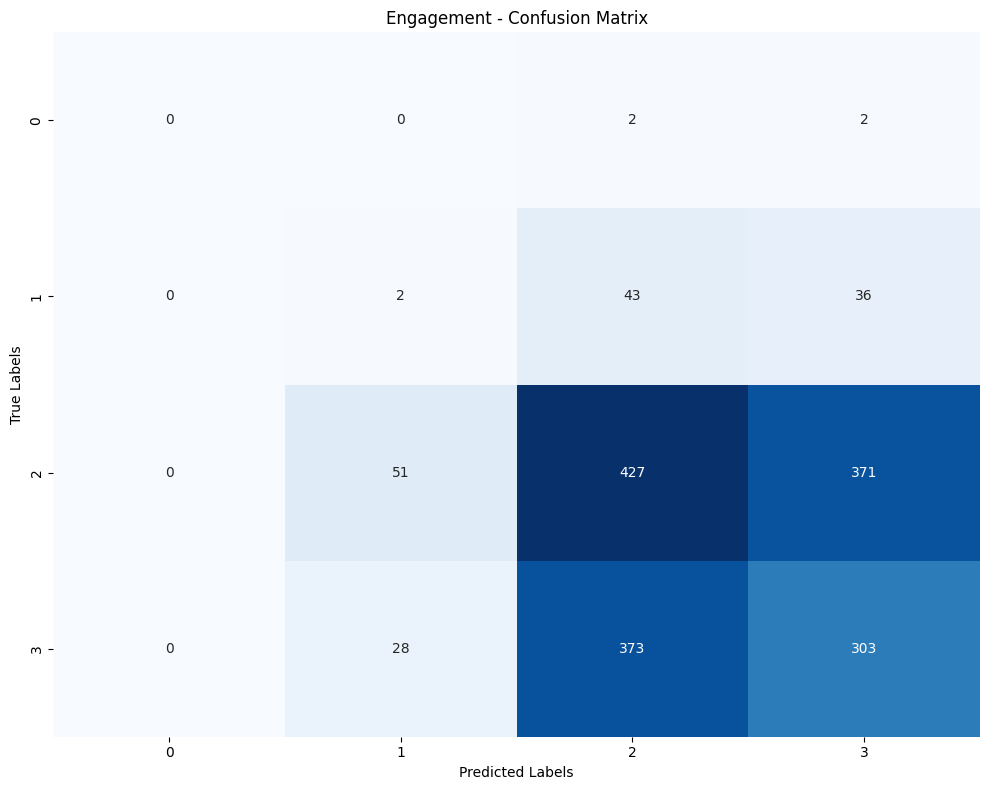

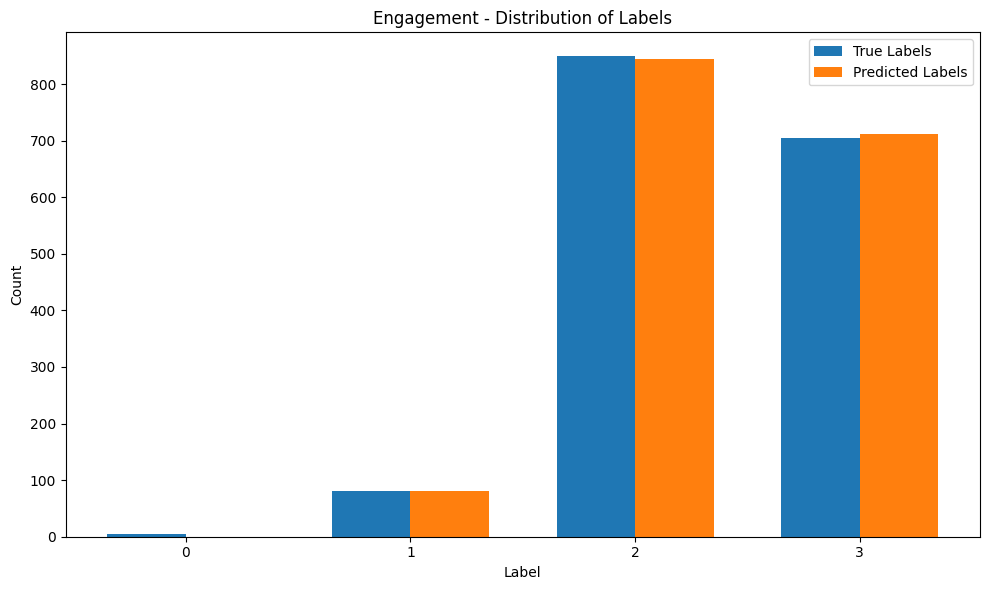

Classification report for Boredom:
              precision    recall  f1-score   support

           0      0.453     0.458     0.455       747
           1      0.347     0.351     0.349       519
           2      0.165     0.161     0.163       335
           3      0.031     0.027     0.029        37

    accuracy                          0.353      1638
   macro avg      0.249     0.249     0.249      1638
weighted avg      0.351     0.353     0.352      1638

Confusion Matrix:
[[342 232 158  15]
 [221 182 104  12]
 [177 100  54   4]
 [ 15  10  11   1]]


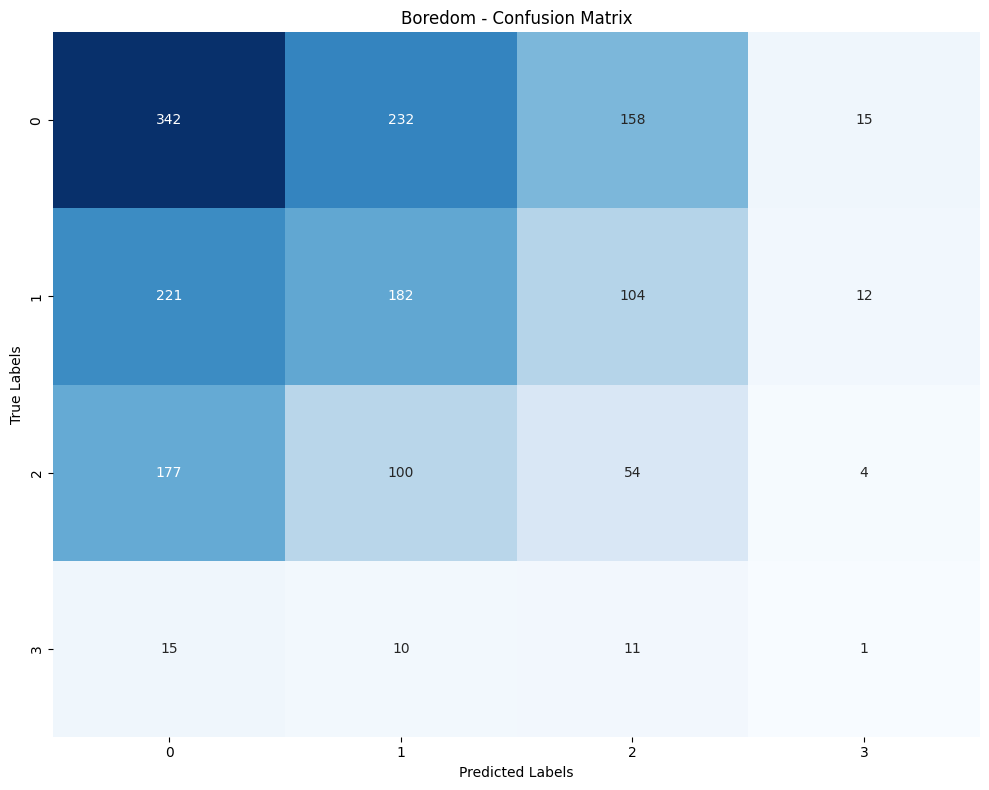

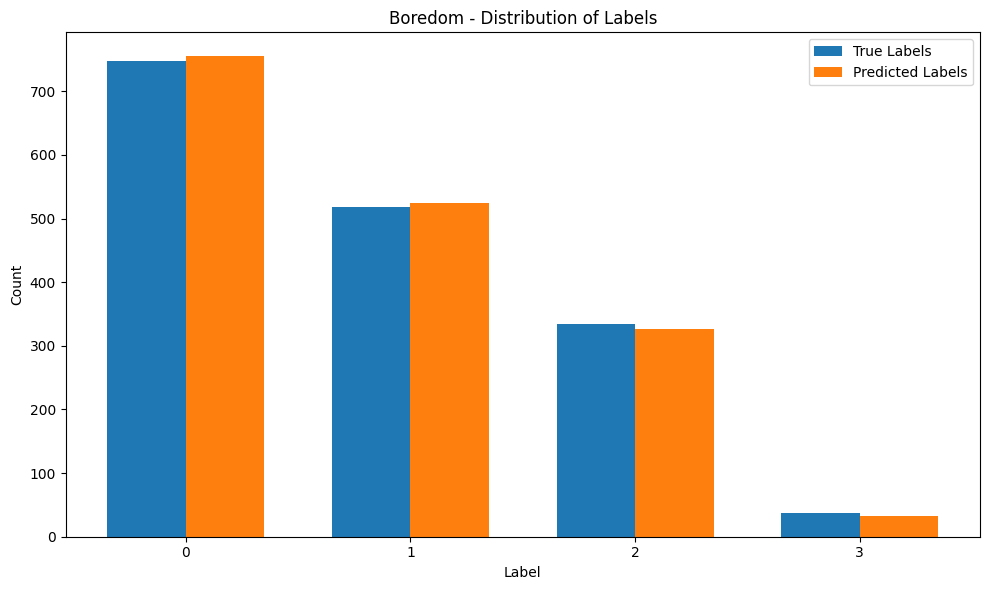

Classification report for Confusion:
              precision    recall  f1-score   support

           0      0.694     0.704     0.699      1135
           1      0.233     0.236     0.235       368
           2      0.071     0.060     0.065       116
           3      0.000     0.000     0.000        19

    accuracy                          0.545      1638
   macro avg      0.250     0.250     0.250      1638
weighted avg      0.538     0.545     0.542      1638

Confusion Matrix:
[[799 253  73  10]
 [259  87  17   5]
 [ 81  27   7   1]
 [ 12   6   1   0]]


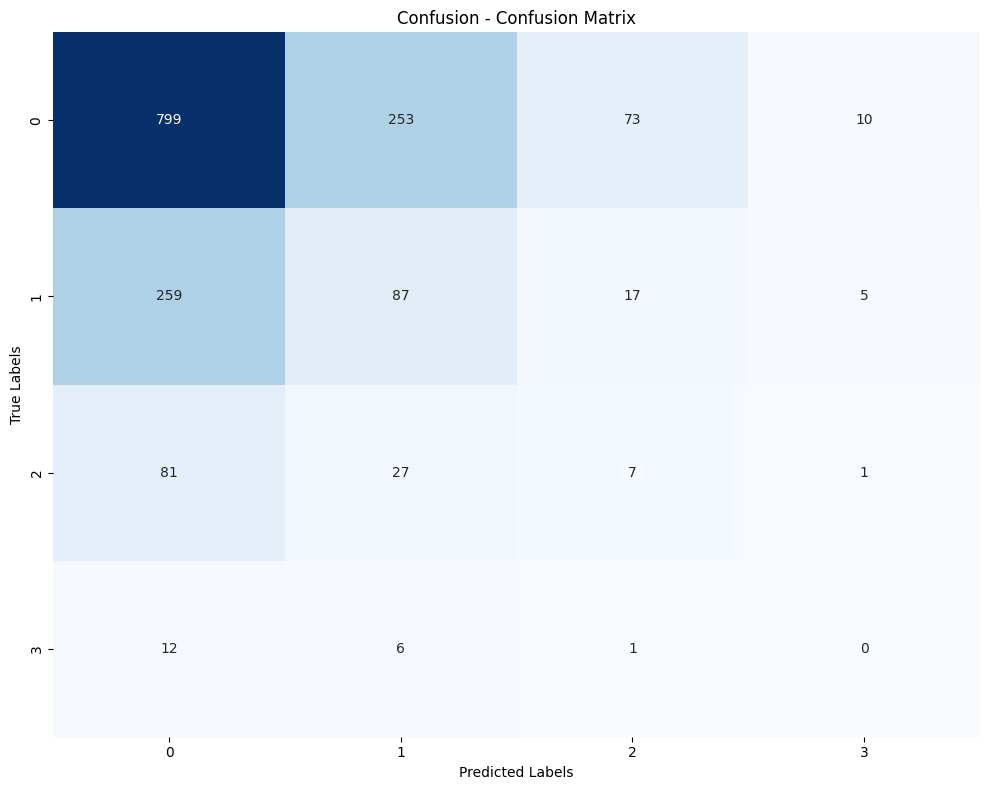

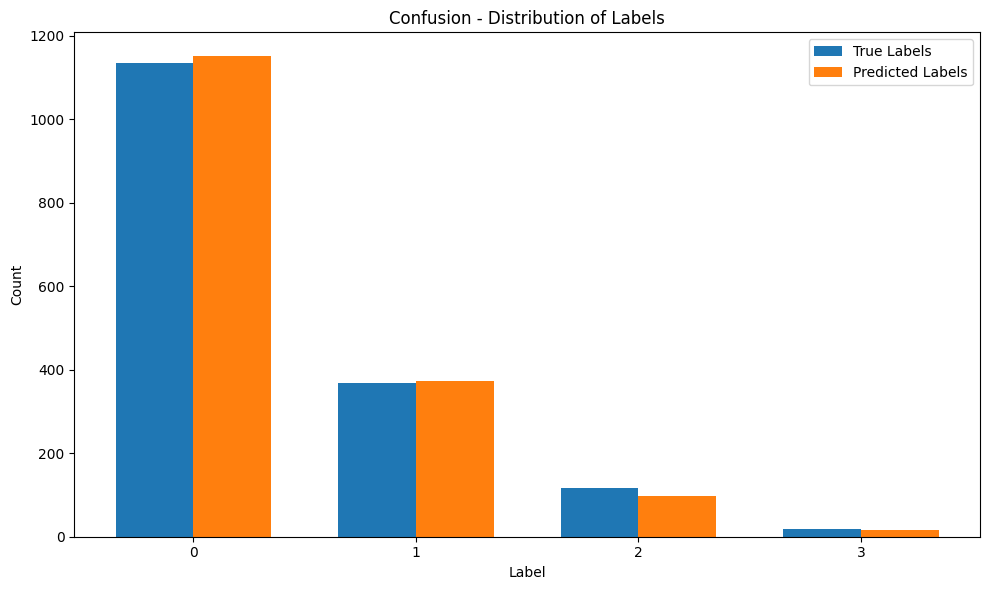

Classification report for Frustration:
              precision    recall  f1-score   support

           0      0.780     0.794     0.787      1279
           1      0.170     0.164     0.167       280
           2      0.000     0.000     0.000        56
           3      0.000     0.000     0.000        23

    accuracy                          0.648      1638
   macro avg      0.237     0.239     0.238      1638
weighted avg      0.638     0.648     0.643      1638

Confusion Matrix:
[[1015  208   43   13]
 [ 225   46    6    3]
 [  43   13    0    0]
 [  19    4    0    0]]


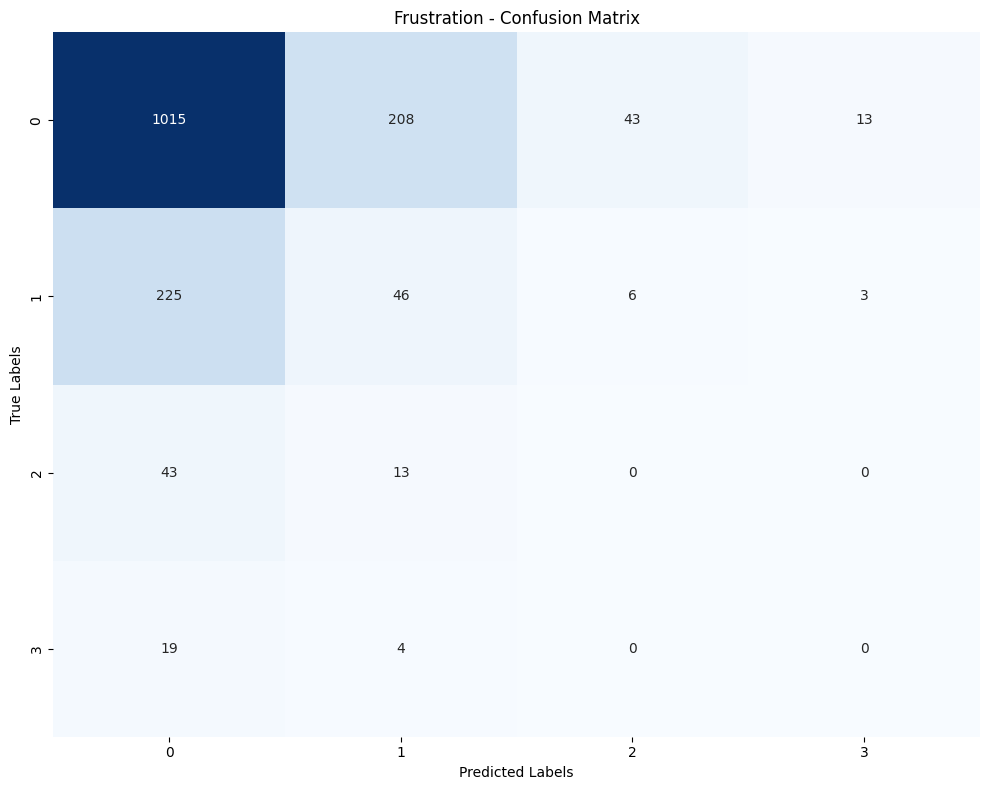

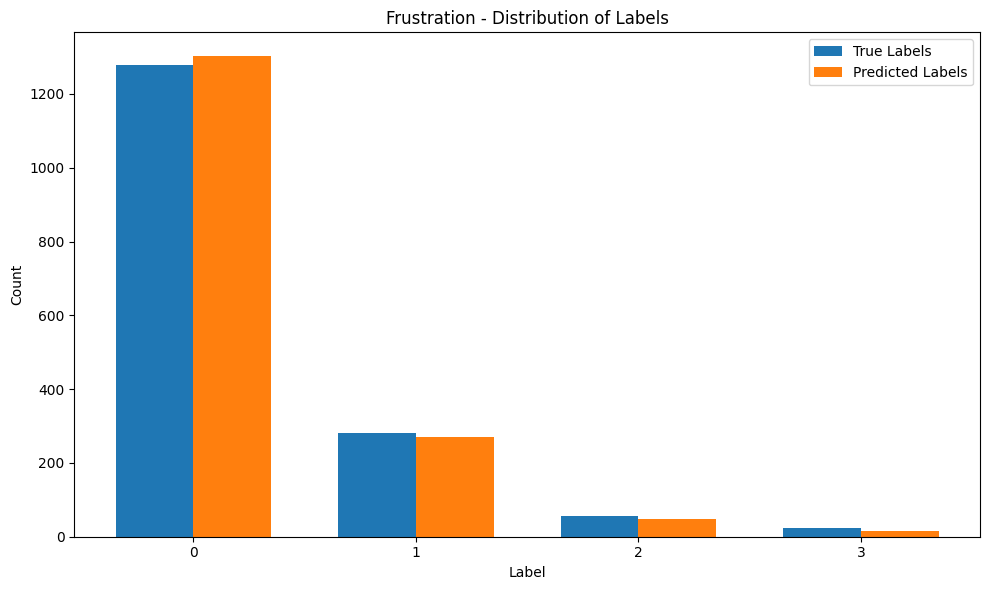


--- Performance Summary vs LCRN ---
Metric       TTA Score  LCRN       Diff      
------------------------------------------
Engagement   0.446      0.579      -0.133
Boredom      0.352      0.537      -0.185
Confusion    0.542      0.723      -0.181
Frustration  0.643      0.735      -0.092

Results saved to: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\results\20250404_162352_single_model_tta

--- Efficient Ensemble Evaluation ---
Using 4 models in ensemble

--- Efficient Ensemble Evaluation (40% of data at 224×224) ---
Using all 4 checkpoints for ensemble evaluation
Loading model 1/4: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\models\final_model_eff_v2l__bilstm_crossattn_cbam_checkpoint.pth
  Detected LSTM hidden size: 512


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/tf_efficientnetv2_l.in21k_ft_in1k)
INFO:timm.models._hub:[timm/tf_efficientnetv2_l.in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


Loading model 2/4: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\models\seed_42_ensemble_model_checkpoint.pth
  Detected LSTM hidden size: 512


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/tf_efficientnetv2_l.in21k_ft_in1k)
INFO:timm.models._hub:[timm/tf_efficientnetv2_l.in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


Loading model 3/4: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\models\seed_101_ensemble_model_checkpoint.pth
  Detected LSTM hidden size: 256


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/tf_efficientnetv2_l.in21k_ft_in1k)
INFO:timm.models._hub:[timm/tf_efficientnetv2_l.in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


Loading model 4/4: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\models\seed_2023_ensemble_model_checkpoint.pth
  Detected LSTM hidden size: 256


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/tf_efficientnetv2_l.in21k_ft_in1k)
INFO:timm.models._hub:[timm/tf_efficientnetv2_l.in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


Evaluating on 327 of 819 batches


Ensemble Evaluation:  40%|███▉      | 327/819 [1:01:20<1:32:16, 11.25s/it]
c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in la

Ensemble classification report for Engagement:
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         2
           1      0.156     0.152     0.154        33
           2      0.583     0.532     0.556       370
           3      0.391     0.446     0.417       249

    accuracy                          0.479       654
   macro avg      0.282     0.282     0.282       654
weighted avg      0.486     0.479     0.481       654

Confusion Matrix:
[[  0   0   0   2]
 [  0   5  14  14]
 [  0  16 197 157]
 [  0  11 127 111]]


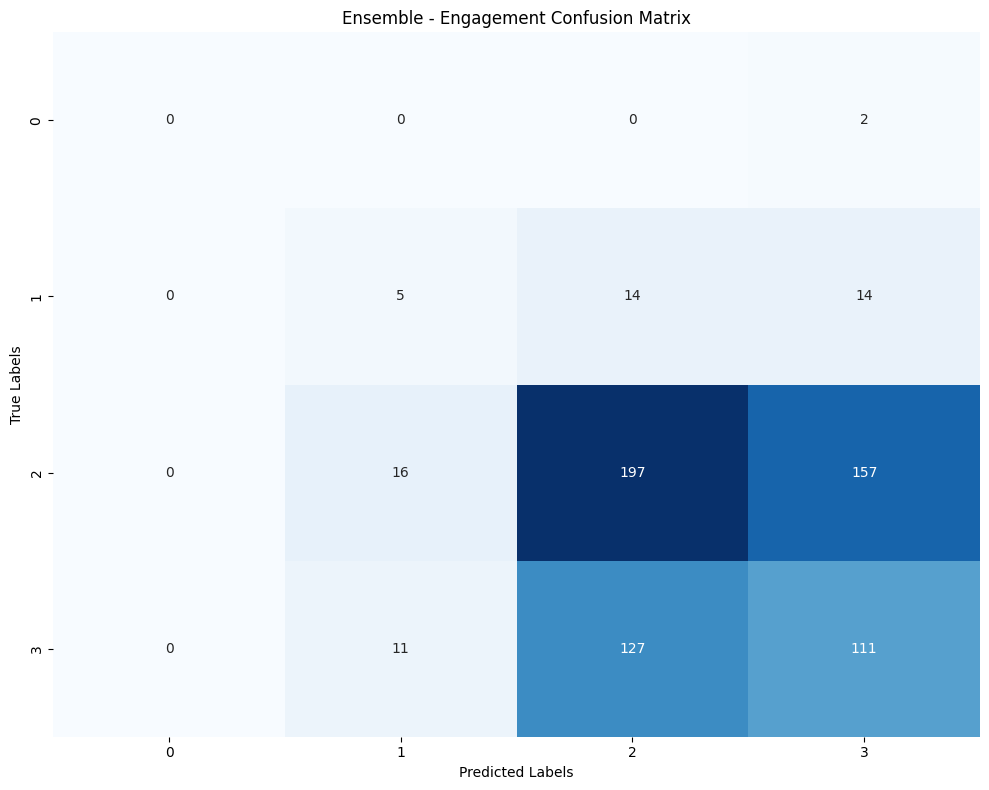

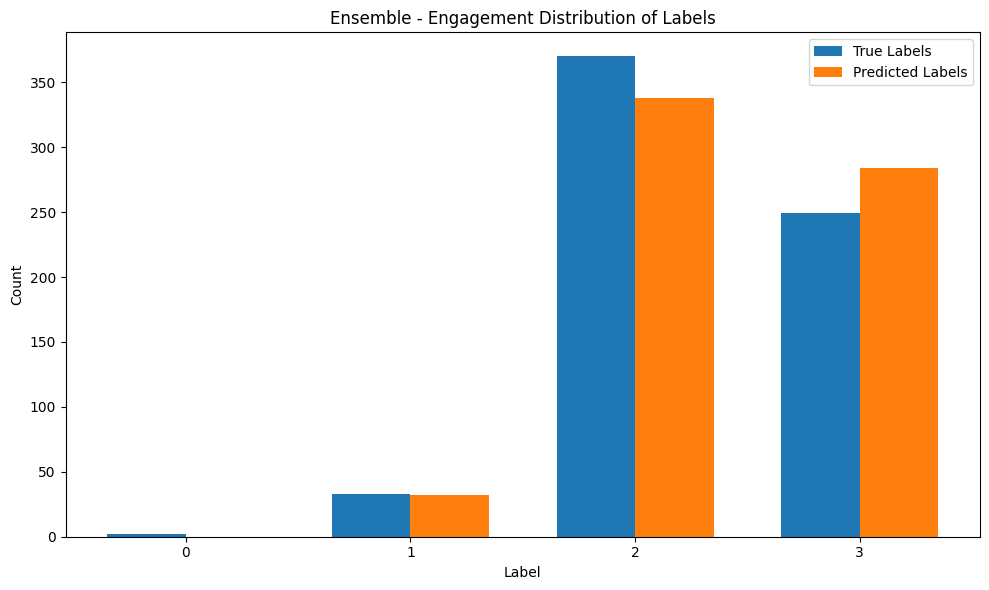

Ensemble classification report for Boredom:
              precision    recall  f1-score   support

           0      0.433     0.482     0.456       276
           1      0.255     0.298     0.275       178
           2      0.333     0.232     0.274       181
           3      0.000     0.000     0.000        19

    accuracy                          0.349       654
   macro avg      0.255     0.253     0.251       654
weighted avg      0.344     0.349     0.343       654

Confusion Matrix:
[[133  92  45   6]
 [ 89  53  34   2]
 [ 76  58  42   5]
 [  9   5   5   0]]


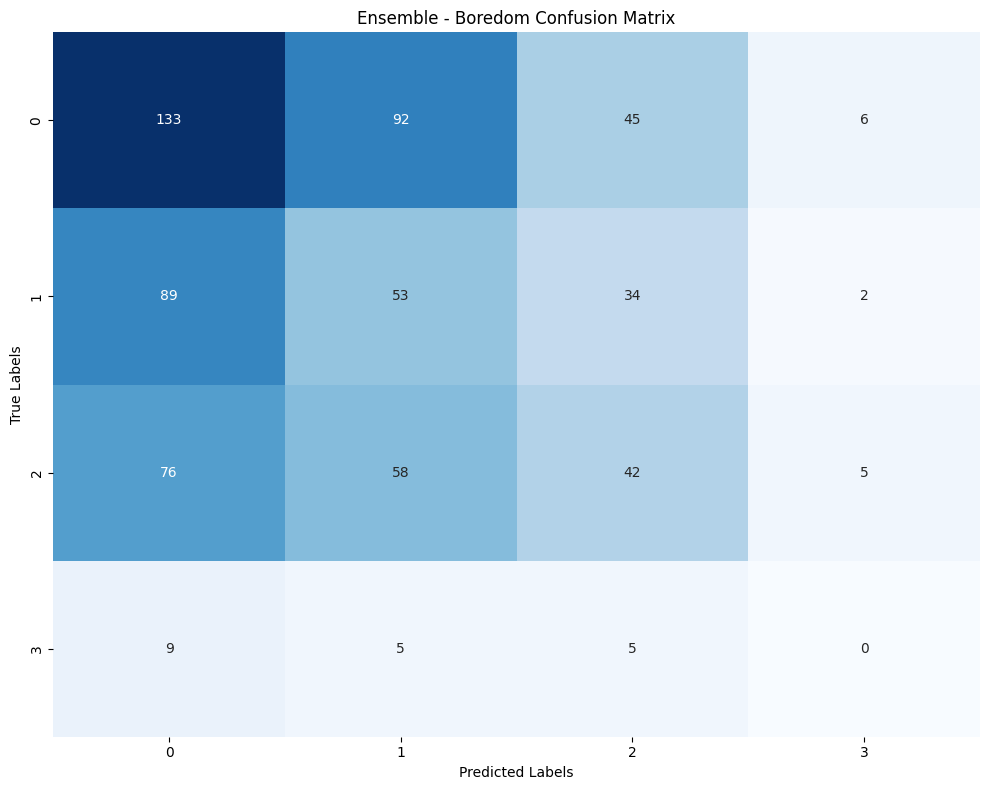

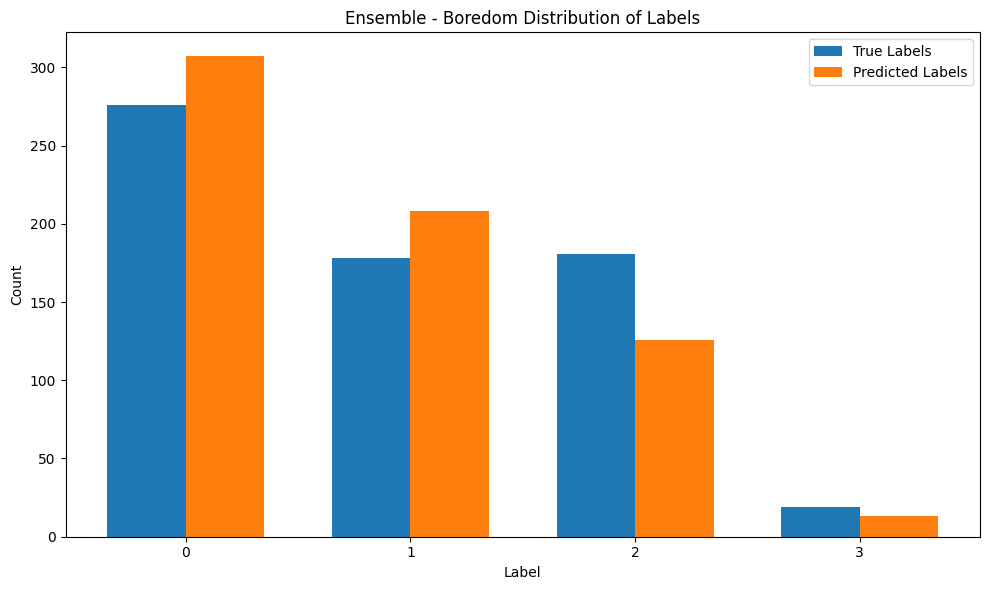

Ensemble classification report for Confusion:
              precision    recall  f1-score   support

           0      0.769     0.733     0.751       505
           1      0.180     0.209     0.193       110
           2      0.000     0.000     0.000        35
           3      0.000     0.000     0.000         4

    accuracy                          0.601       654
   macro avg      0.237     0.235     0.236       654
weighted avg      0.624     0.601     0.612       654

Confusion Matrix:
[[370 101  28   6]
 [ 76  23  11   0]
 [ 31   4   0   0]
 [  4   0   0   0]]


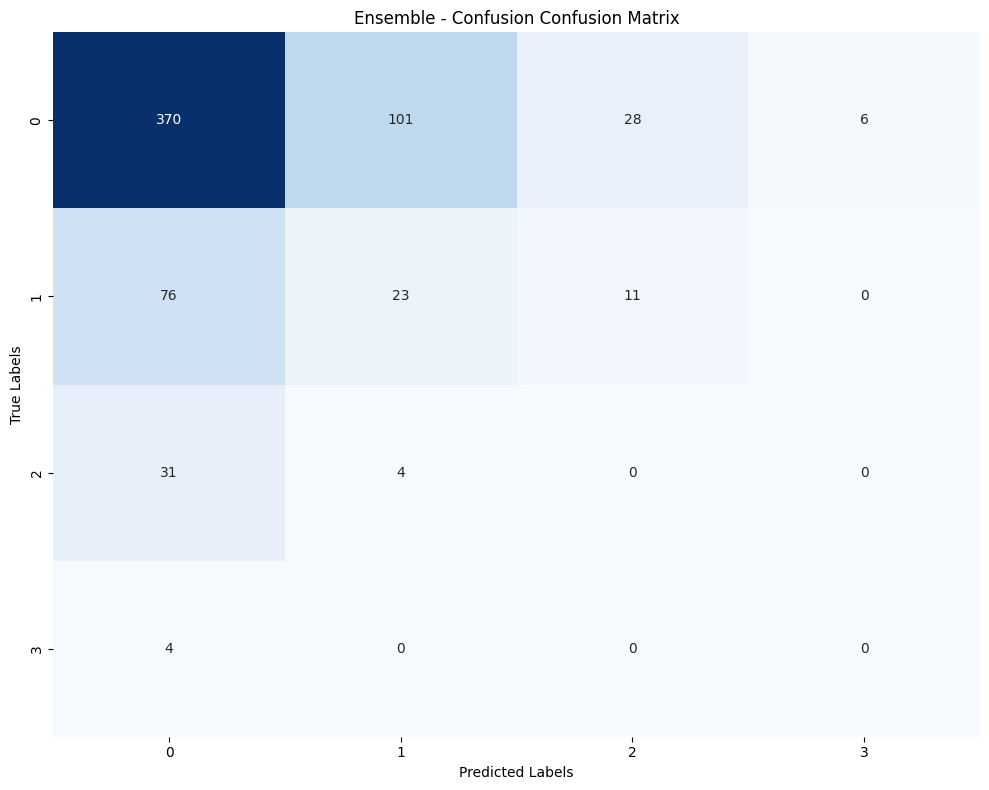

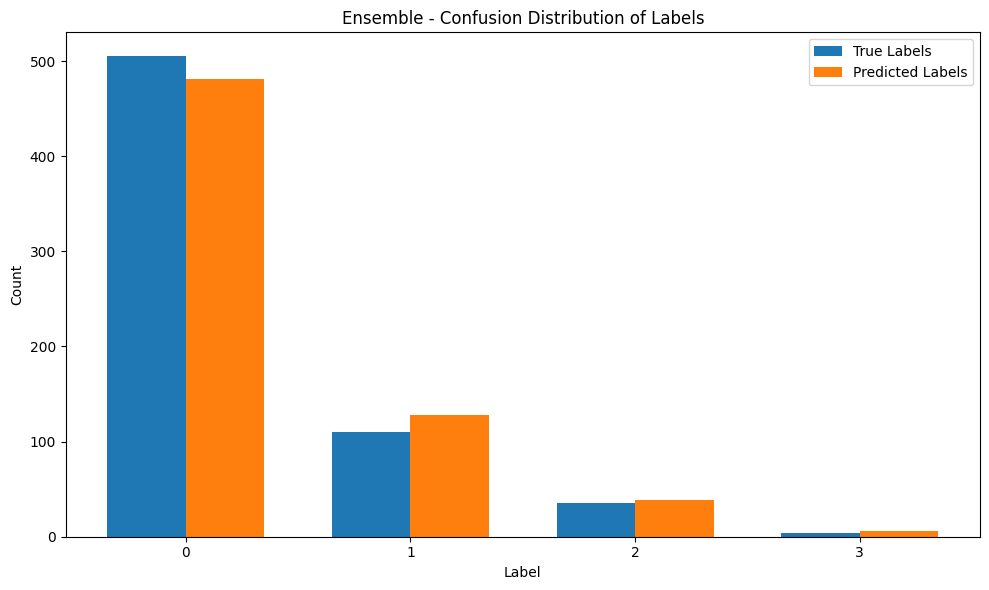

Ensemble classification report for Frustration:
              precision    recall  f1-score   support

           0      0.829     0.804     0.816       542
           1      0.098     0.108     0.103        93
           2      0.000     0.000     0.000        12
           3      0.000     0.000     0.000         7

    accuracy                          0.682       654
   macro avg      0.232     0.228     0.230       654
weighted avg      0.701     0.682     0.691       654

Confusion Matrix:
[[436  86  16   4]
 [ 77  10   4   2]
 [  6   6   0   0]
 [  7   0   0   0]]


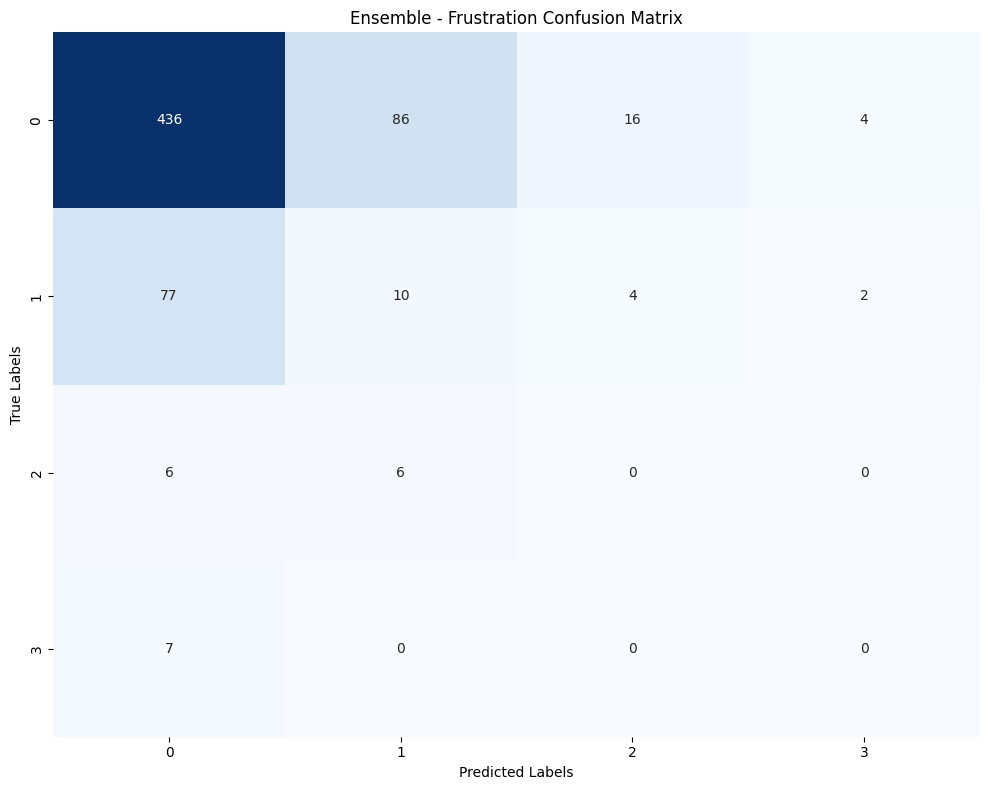

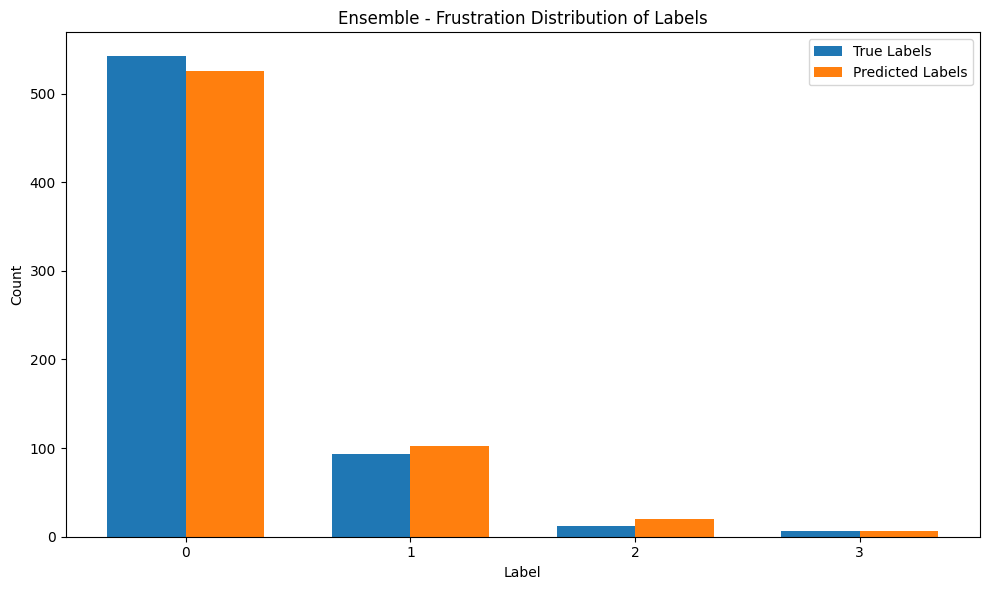


--- Efficient Ensemble Results vs LCRN ---
Metric       Ensemble   LCRN       Diff      
------------------------------------------
Engagement   0.481      0.579      -0.098
Boredom      0.343      0.537      -0.194
Confusion    0.612      0.723      -0.111
Frustration  0.691      0.735      -0.044

Results saved to: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\results\20250404_172539_ensemble_evaluation

--- Final Comparison Summary ---
Base Full.py (from literature): Frustration 78.1% (beats LCRN)
LCRN: Engagement 57.9%, Boredom 53.7%, Confusion 72.3%, Frustration 73.5%
Our Single Model+TTA: Engagement 44.6%, Boredom 35.2%, Confusion 54.2%, Frustration 64.3%
Our Efficient Ensemble: Engagement 48.1%, Boredom 34.3%, Confusion 61.2%, Frustration 69.1%

Final comparison saved to: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\results\20250404_172540_final_comparison.json

--- Evaluation Complete ---


In [5]:
# ------------------------------
# Main Execution
# ------------------------------
if __name__ == "__main__":
    torch.multiprocessing.set_start_method('spawn')
    
    # CSV file paths
    train_csv = LABELS_DIR / "TrainLabels.csv"
    val_csv = LABELS_DIR / "ValidationLabels.csv"
    test_csv = LABELS_DIR / "TestLabels.csv"
    
    # Precompute caches and LMDB for each resolution
    resolutions = [112, 224, 300]
    for csv in [train_csv, val_csv, test_csv]:
        for res in resolutions:
            precompute_best_frames(csv, FRAMES_DIR, num_frames=NUM_FRAMES, resolution=res)
            convert_pkl_to_lmdb(csv, num_frames=NUM_FRAMES, resolution=res,
                                transform=get_transform(res), lmdb_map_size=1 * 1024**3)
    
    # ------------------------------
    # Hyperparameter Tuning using Progressive Training over All 3 Resolutions
    # ------------------------------
    def objective(trial):
        torch.cuda.empty_cache()
        gc.collect()
        batch_size = trial.suggest_categorical("batch_size", [4, 8])
        lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
        lstm_hidden = trial.suggest_categorical("lstm_hidden", [256, 512])
        lstm_layers = trial.suggest_categorical("lstm_layers", [1, 2])
        dropout_rate = trial.suggest_categorical("dropout_rate", [0.4, 0.5])
        total_epochs = sum(eps for _, eps in PROG_SCHEDULE)
        model = EfficientNetV2L_BiLSTM_CrossAttn_CBAM(lstm_hidden=lstm_hidden, lstm_layers=lstm_layers,
                                                       dropout_rate=dropout_rate, classifier_hidden=256).to(device)
        trial_checkpoint = MODEL_DIR / f"trial_eff_v2l_{trial.number}__bilstm_crossattn_cbam_checkpoint.pth"
        trial_checkpoint.parent.mkdir(parents=True, exist_ok=True)
        loss = progressive_train_model(model, total_epochs, lr, trial_checkpoint, batch_size,
                                       patience=3, gradient_accum_steps=GRADIENT_ACCUM_STEPS)
        del model
        torch.cuda.empty_cache()
        gc.collect()
        return loss
    
    db_path = BASE_DIR / "notebooks" / "tuning_eff_v2l_bilstm_crossattn_cbam.db"
    db_path.parent.mkdir(parents=True, exist_ok=True)
    try:
        conn = sqlite3.connect(db_path)
        print(f"Database created/connected at: {db_path}")
        conn.close()
    except Exception as e:
        print(f"DB Error: {e}")
    study = optuna.create_study(
        direction="minimize",
        pruner=MedianPruner(n_startup_trials=2, n_warmup_steps=10),
        study_name="efficientnetv2l_bilstm_crossattn_cbam_study",
        storage=f"sqlite:///{db_path}",
        load_if_exists=True
    )
    target_trials = 30
    while True:
        successes = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE and np.isfinite(t.value)]
        remaining = target_trials - len(successes)
        if remaining <= 0:
            break
        print(f"Running {remaining} additional trial(s) to reach {target_trials} successful trials...")
        study.optimize(objective, n_trials=remaining, catch=(Exception,))
    print(f"Optuna tuning complete. Total successful trials: {len(successes)}")
    best_trial = min(successes, key=lambda t: t.value)
    print(f"Best trial parameters: {best_trial.params}")
    
    # ------------------------------
    # Final Training (using raw images for end-to-end fine-tuning)
    # ------------------------------
    total_epochs = sum(eps for _, eps in PROG_SCHEDULE)
    final_checkpoint = MODEL_DIR / "final_model_eff_v2l__bilstm_crossattn_cbam_checkpoint.pth"
    if not final_checkpoint.exists():
        print("\n--- Starting Final Training ---")
        params = best_trial.params
        batch_size = params.get("batch_size", 4)
        lr = params.get("lr", 1e-4)
        lstm_hidden = params.get("lstm_hidden", 256)
        lstm_layers = params.get("lstm_layers", 1)
        dropout_rate = params.get("dropout_rate", 0.5)
        final_model = EfficientNetV2L_BiLSTM_CrossAttn_CBAM(lstm_hidden=lstm_hidden, lstm_layers=lstm_layers,
                                                             dropout_rate=dropout_rate, classifier_hidden=256).to(device)
        # Unfreeze backbone layers after stage 6 for fine-tuning
        if hasattr(final_model.backbone, "blocks"):
            for i, block in enumerate(final_model.backbone.blocks):
                if i >= 6:
                    for param in block.parameters():
                        param.requires_grad = True
        final_checkpoint.parent.mkdir(parents=True, exist_ok=True)
        final_loss = progressive_train_model(final_model, total_epochs, lr, final_checkpoint, batch_size,
                                             patience=5, gradient_accum_steps=GRADIENT_ACCUM_STEPS)
    else:
        print("\n--- Skipping Final Training (Checkpoint Exists) ---")
        print(f"Using existing model from: {final_checkpoint}")
    
    # ------------------------------
    # Evaluation on Test Set using Highest Resolution (300x300)
    # ------------------------------
    print("\n--- Starting Evaluation ---")
    test_transform = get_transform(300)
    test_set = VideoDatasetRaw(test_csv, FRAMES_DIR, num_frames=NUM_FRAMES, transform=test_transform)
    
    # Reduce batch size for efficiency
    batch_size = min(best_trial.params.get("batch_size", 4), 2)  # Smaller batch size
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
    
    # First evaluate using the original final checkpoint with horizontal flip only
    print(f"Loading model from: {final_checkpoint}")
    
    # Detect LSTM hidden size from the checkpoint
    state = torch.load(final_checkpoint, map_location=device)
    lstm_hidden = 256  # Default
    for key, param in state["model_state_dict"].items():
        if key == "bilstm.weight_ih_l0":
            lstm_hidden = param.shape[0] // 4
            print(f"Detected LSTM hidden size: {lstm_hidden}")
            break
            
    eval_model = EfficientNetV2L_BiLSTM_CrossAttn_CBAM(
        lstm_hidden=lstm_hidden,
        lstm_layers=best_trial.params.get("lstm_layers", 1),
        dropout_rate=best_trial.params.get("dropout_rate", 0.5),
        classifier_hidden=256
    ).to(device)
    
    eval_model.load_state_dict(state["model_state_dict"])
    
    # Single model evaluation with TTA
    print("\n--- Evaluating Single Model with TTA ---")
    single_results = evaluate_model(eval_model, test_loader)
    
    # ------------------------------
    # Define paths to ensemble models
    # ------------------------------
    # Check for existing seed model checkpoints
    ensemble_seed_checkpoints = [
        MODEL_DIR / f"seed_42_ensemble_model_checkpoint.pth",
        MODEL_DIR / f"seed_101_ensemble_model_checkpoint.pth",
        MODEL_DIR / f"seed_2023_ensemble_model_checkpoint.pth"
    ]
    
    # Filter to only include checkpoints that actually exist
    ensemble_seed_checkpoints = [path for path in ensemble_seed_checkpoints if path.exists()]
    
    # If no seed checkpoints found, just duplicate the final checkpoint
    if not ensemble_seed_checkpoints:
        print("No seed checkpoints found. Using final checkpoint twice for ensemble.")
        ensemble_seed_checkpoints = [final_checkpoint]
    
    # Then evaluate using the efficient ensemble with all available models
    print("\n--- Efficient Ensemble Evaluation ---")
    # Use all seed files + final checkpoint
    selected_checkpoints = [final_checkpoint] + ensemble_seed_checkpoints
    print(f"Using {len(selected_checkpoints)} models in ensemble")
    ensemble_results = efficient_ensemble_evaluate(
        selected_checkpoints, 
        test_loader,
        subset_size=0.4,  # Use 40% of test data to balance more models
        resolution=224    # Lower resolution for speed
    )
    
    # Print final comparison and save overall results
    print("\n--- Final Comparison Summary ---")
    print("Base Full.py (from literature): Frustration 78.1% (beats LCRN)")
    print("LCRN: Engagement 57.9%, Boredom 53.7%, Confusion 72.3%, Frustration 73.5%")
    print(f"Our Single Model+TTA: {', '.join([f'{k} {v*100:.1f}%' for k, v in single_results.items()])}")
    print(f"Our Efficient Ensemble: {', '.join([f'{k} {v*100:.1f}%' for k, v in ensemble_results.items()])}")

    # Save final comparison
    final_results = {
        "Single_Model": single_results,
        "Ensemble": ensemble_results
    }
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    results_file = BASE_DIR / "results" / f"{timestamp}_final_comparison.json"
    with open(results_file, "w") as f:
        import json
        json.dump(final_results, f, indent=4)
    print(f"\nFinal comparison saved to: {results_file}")

    torch.cuda.empty_cache()
    gc.collect()
    print("\n--- Evaluation Complete ---")